# [과제 2] 회귀분석

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import warnings
warnings.filterwarnings(action='ignore')

# Data 

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [41]:
# Load Data 
data = pd.read_csv("assignment2_data.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


데이터 저장과정에서 추가된 것으로 보이는 Unnamed: 0 칼럼은 제거하였습니다.

In [42]:
data = data.drop(columns=['Unnamed: 0'])

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


# 1. 데이터 확인 + 전처리

Mileage, Engine, Power 의 경우 각각 kmpl, CC, bhp 단위가 함께 표기되어 있습니다. 정규표현식을 이용해 해당부분을 지우고 Dtype 을 float64 형태로 바꿔주었습니다.

In [44]:
pattern = "(\s{1}kmpl$|\s{1}km/kg$|\s{1}bhp$|\s{1}CC$)"
'''
dtype 변환 과정에서 오류가 발생하여 확인해보니 power 데이터에는 null bhp 라는 값을 가진 행이 존재하였습니다.
'''
data['Power'] = data['Power'].apply(lambda x: None if x == "null bhp" else x)

data['Mileage'] = data['Mileage'].replace((re.compile(pattern)),"").astype('float')
data['Engine'] = data['Engine'].replace((re.compile(pattern)),"").astype('float')
data['Power'] = data['Power'].replace((re.compile(pattern)),"").astype('float')

In [45]:
data.isnull().sum()/len(data)

Name                 0.000000
Location             0.000000
Year                 0.000000
Kilometers_Driven    0.000000
Fuel_Type            0.000000
Transmission         0.000000
Owner_Type           0.000000
Mileage              0.000332
Engine               0.005981
Power                0.023758
Seats                0.006978
New_Price            0.863100
Price                0.000000
dtype: float64

In [46]:
data.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                 143
Seats                  42
New_Price            5195
Price                   0
dtype: int64

New_Price 의 경우 결측치 비율이 0.863 으로 매우 높아 결측치를 채워주는 것 보다는 삭제하는 것이 나을 것 같습니다.

In [47]:
data = data.drop(columns=['New_Price'])

Mileage 의 경우 결측치가 2개 존재합니다. 동일한 차량의 마일리지를 찾아보려 하였으나 데이터 상에 존재하지 않았고 회사명인 Mahindra, Toyota 의 차량들의 평균값으로 결측치를 채워주었습니다.

In [48]:
data[data['Mileage'].isnull()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72.0,41.0,5.0,13.00
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0,12.75


In [49]:
data[data['Name'].str.contains('Mahindra')].describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,272.000000,272.000000,271.000000,272.000000,269.000000,272.000000,272.000000
mean,2013.731618,69172.327206,15.051144,2126.474265,121.285502,7.033088,8.045919
std,3.080356,35776.282814,2.931813,381.381407,28.070770,0.678348,3.598662
min,2000.000000,2200.000000,0.000000,72.000000,41.000000,5.000000,1.500000
25%,2012.000000,43943.250000,13.600000,2179.000000,105.000000,7.000000,5.500000
50%,2014.000000,65606.500000,15.100000,2179.000000,120.000000,7.000000,7.570000
75%,2016.000000,86022.750000,16.000000,2179.000000,140.000000,7.000000,10.082500
max,2019.000000,234000.000000,25.320000,2696.000000,184.000000,9.000000,17.630000


In [50]:
data[data['Name'].str.contains('Toyota')].describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,411.000000,411.000000,410.000000,410.000000,395.000000,410.000000,411.000000
mean,2013.007299,83642.445255,14.380390,2311.519512,128.921063,6.502439,11.580024
std,3.355730,51134.688973,3.637018,567.527551,35.391730,1.168555,7.001564
min,2001.000000,1331.000000,0.000000,1197.000000,67.040000,5.000000,1.500000
25%,2011.000000,48000.000000,12.550000,1798.000000,100.600000,5.000000,5.550000
50%,2013.000000,71000.000000,12.990000,2494.000000,138.000000,7.000000,10.750000
75%,2015.000000,105536.000000,14.530000,2755.000000,168.500000,7.000000,16.500000
max,2019.000000,299322.000000,23.590000,2982.000000,178.400000,10.000000,35.820000


결측치 처리에 있어 회사명을 활용하면 편할 것 같아 회사명에 대한 변수를 추가하겠습니다.

In [51]:
data['company'] = data['Name'].str.split().str[0]

In [52]:
data['Mileage'].iloc[4446] = data[data['company']== 'Mahindra']['Mileage'].mean()

In [53]:
data['Mileage'].iloc[4904] = data[data['company']== 'Toyota']['Mileage'].mean()

다음으로 Engine, Power, Seats 에 대한 결측치를 확인해보았습니다. 해당 칼럼들의 경우 대부분 겹치는 인덱스입니다.

In [54]:
data.isnull().sum()

Name                   0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                0
Engine                36
Power                143
Seats                 42
Price                  0
company                0
dtype: int64

In [55]:
data[data['Seats'].isnull()].head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,company
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,0.0,NaN,NaN,NaN,2.95,Honda
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001,Petrol,Manual,First,16.1,NaN,NaN,NaN,2.11,Maruti
229,Ford Figo Diesel,Bangalore,2015,70436,Diesel,Manual,First,0.0,1498.0,99.0,NaN,3.60,Ford
733,Maruti Swift 1.3 VXi,Chennai,2006,97800,Petrol,Manual,Third,16.1,NaN,NaN,NaN,1.75,Maruti
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001,Diesel,Automatic,Second,0.0,NaN,NaN,NaN,26.50,Land


전체 피처 중 3개가 null 값이면 값을 채우는 의미가 없다고 생각하여 Engine, Power, Seats 중 2개 이상의 값이 null 인경우 제거하였습니다. 이후 회사의 평균 값으로 결측치를 처리해주었습니다.

In [56]:
index1 = list(data[ (data['Engine'].isnull()) & (data['Power'].isnull()) ].index) # 엔진 + 파워
index2 = list(data[ (data['Seats'].isnull()) & (data['Power'].isnull()) ].index ) # 시트 + 파워
index3 = list(data[ (data['Engine'].isnull()) & (data['Seats'].isnull()) ].index)  # 엔진 + 시트

In [57]:
drop_index = set(index1+index2+index3)

In [58]:
data = data.drop(index=drop_index)

In [59]:
data.isnull().sum()

Name                   0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                0
Engine                 0
Power                103
Seats                  2
Price                  0
company                0
dtype: int64

In [60]:
fill_company_mean = lambda g : g.fillna(g.mean())
data = data.groupby('company').apply(fill_company_mean)

In [61]:
data.isnull().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                1
Seats                0
Price                0
company              0
dtype: int64

In [62]:
data[data['Power'].isnull()] # -> 그냥 제거하겠습니다.

,,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,company
company,,,,,,,,,,,,,,
Smart,915,Smart Fortwo CDI AT,Pune,2008,103000,Diesel,Automatic,Second,0.0,799.0,NaN,2.0,3.0,Smart


In [63]:
data=data.dropna()

In [64]:
data = data.reset_index(drop=True)
data.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,company
0,Ambassador Classic Nova Diesel,Chennai,2003,80000,Diesel,Manual,Third,12.80,1489.0,35.50,5.0,1.35,Ambassador
1,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,Audi
2,Audi A6 2011-2015 35 TFSI Technology,Mumbai,2015,55985,Petrol,Automatic,First,13.53,1984.0,177.01,5.0,23.50,Audi


In [65]:
# fig, ax = plt.subplots(3, 3, figsize=(15, 10), constrained_layout=True)
# ax = ax.flatten()

# i = 0
# for col in int_col:
#     ax[i].set(title = col)
#     sns.kdeplot(data[col], palette = "Set3", ax=ax[i])
#     i+=1
    
# plt.show()

Owner_Type 의 경우 1,2,3,4 로 바꿔 int 형 변수로 취하겠습니다.

In [66]:
data['Owner_Type'].unique()

array(['Third', 'Second', 'First', 'Fourth & Above'], dtype=object)

In [67]:
data['Owner_Type']=data['Owner_Type'].replace(['Third', 'Second', 'First', 'Fourth & Above'],[3,2,1,4])
data['Owner_Type']=data['Owner_Type'].astype(int)

In [68]:
data['Owner_Type'].unique() # -> 바뀐거 확인

array([3, 2, 1, 4])

# 2. 회귀분석 + 회귀진단

Name 의 경우 더미변수화 시키기에 유니크 값이 많아서 company를 더미변수화 시키겠습니다. company를 그룹으로 묶어 카운트를 확인해봤을 때, Ambassador, Bentley, Force, ISUZU, Isuzu, Lamborghini 는 카운트가 5 이하이므로 더미변수 생성에서 제거하겠습니다.

In [72]:
data['Name'].nunique() 

1857

In [73]:
data['company'].nunique()

30

In [76]:
data.groupby(['company']).count().iloc[:,0]

company
Ambassador          1
Audi              236
BMW               262
Bentley             1
Chevrolet         121
Datsun             13
Fiat               25
Force               3
Ford              299
Honda             602
Hyundai          1100
ISUZU               2
Isuzu               1
Jaguar             40
Jeep               15
Lamborghini         1
Land               57
Mahindra          272
Maruti           1197
Mercedes-Benz     318
Mini               26
Mitsubishi         27
Nissan             91
Porsche            18
Renault           145
Skoda             173
Tata              186
Toyota            410
Volkswagen        315
Volvo              21
Name: Name, dtype: int64

In [78]:
str_col = ['Location','Fuel_Type','Transmission','company']
int_col = data.describe().columns

In [81]:
data_cat = data[str_col]
data_cat = pd.get_dummies(data_cat)
data_cat = data_cat.drop(columns=['company_Ambassador', 'company_Bentley', 'company_Force', 
                                  'company_ISUZU', 'company_Isuzu', 'company_Lamborghini'])
data_int = data[int_col]
data_dum = pd.concat([data_int, data_cat], axis=1)

In [83]:
data_dum.head() # 데이터 확인

,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,Location_Ahmedabad,Location_Bangalore,...,company_Mini,company_Mitsubishi,company_Nissan,company_Porsche,company_Renault,company_Skoda,company_Tata,company_Toyota,company_Volkswagen,company_Volvo
0,2003,80000,3,12.80,1489.0,35.50,5.0,1.35,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013,40670,2,15.20,1968.0,140.80,5.0,17.74,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,55985,1,13.53,1984.0,177.01,5.0,23.50,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2010,35000,1,12.40,2698.0,179.50,5.0,11.50,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,13648,1,17.11,1968.0,174.33,5.0,21.43,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
y = data_dum["Price"]
X = data_dum.drop(['Price'], axis=1)

In [89]:
import statsmodels.api as sm

model = sm.OLS(y, X)
result = model.fit()result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     434.8
Date:                Sat, 28 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:53:39   Log-Likelihood:                -18517.
No. Observations:                5978   AIC:                         3.713e+04
Df Residuals:                    5931   BIC:                         3.744e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Year                       1.0295      0.028     36.824      0.000       0.975       1.084
Kilometers_Driven        1.56e-06   7.87e-07      1.983      0.047    1.78e-08     3.1e-06
Owner_Type                -0.2434      0.172     -1.415      0.157      -0.581       0.094
Mileage                   -0.1156      0.027     -4.277      0.000      -0.169      -0.063
Engine                     0.0017      0.000      4.492      0.000       0.001       0.002
Power                      0.0892      0.004     22.455      0.000       0.081       0.097
Seats                     -0.0467      0.134     -0.348      0.728      -0.310       0.217
Location_Ahmedabad      -237.7332      6.457    -36.818      0.000    -250.391    -225.075
Location_Bangalore      -235.9263      6.460    -36.522      0.000    -248.590    -223.263
Location_Chennai        -236.7215      6.437    -36.776      0.000    -249.340    -224.103
Location_Coimbatore     -235.8922      6.504    -36.268      0.000    -248.643    -223.142
Location_Delhi          -238.2733      6.455    -36.913      0.000    -250.927    -225.619
Location_Hyderabad      -236.1656      6.435    -36.700      0.000    -248.781    -223.551
Location_Jaipur         -237.0252      6.446    -36.770      0.000    -249.662    -224.388
Location_Kochi          -237.9420      6.503    -36.591      0.000    -250.690    -225.194
Location_Kolkata        -238.6792      6.441    -37.057      0.000    -251.306    -226.053
Location_Mumbai         -238.3099      6.457    -36.906      0.000    -250.968    -225.651
Location_Pune           -237.4782      6.446    -36.840      0.000    -250.115    -224.841
Fuel_Type_CNG           -524.3820     14.222    -36.871      0.000    -552.263    -496.501
Fuel_Type_Diesel        -524.4624     14.223    -36.874      0.000    -552.345    -496.580
Fuel_Type_Electric      -513.2066     14.576    -35.210      0.000    -541.780    -484.633
Fuel_Type_LPG           -522.9089     14.256    -36.679      0.000    -550.857    -494.961
Fuel_Type_Petrol        -525.1866     14.223    -36.926      0.000    -553.068    -497.305
Transmission_Automatic -1305.0921     35.516    -36.747      0.000   -1374.716   -1235.469
Transmission_Manual    -1305.0543     35.478    -36.785      0.000   -1374.605   -1235.504
company_Audi               0.4094      1.848      0.222      0.825      -3.213       4.031
company_BMW               -0.4465      1.846     -0.242      0.809      -4.065       3.172
company_Chevrolet         -8.3850      1.891     -4.435      0.000     -12.091      -4.679
company_Datsun            -9.3639      2.375     -3.943      0.000     -14.019      -4.709
company_Fiat              -8.0635      2.121     -3.801      0.000     -12.222      -3.905
company_Ford              -7.5803      1.846     -4.106      0.000     -11.199  

- 칼럼 전체에 대하여 다음과 같은 설명력을 갖습니다. 0.7 이상으로 어느정도의 설명력을 갖고 있다고 생각됩니다.

    **`R-squared`** : 0.771

    **`Adj. R-squared`** : 0.769

- Owner_Type, Seats, company_Audi, company_BMW, company_Mercedes-Benz 칼럼의 경우 유의확률(0.05) 보다 커 통계적으로 유의하지 않아보입니다. 

- 왜도는 0에 가까울 수록 대칭이며 첨도는 3에 가까울수록 정규분포를 따르는데 현재 대칭 및 정규분포의 꼴을 만족하지 않아 보입니다.
    
    **`Skew`**:	3.063	
    
    **`Kurtosis`**:	50.522

- Durbin-Watson 통계량이 2에 가깝기 때문에 오차항이 독립성을 만족하는 것으로 보입니다.

#### 타겟 변수에 로그를 취해 정규분포꼴로 바꿔준 후 다시 확인해보겠습니다.

In [95]:
# 로그 변환
log_y= y.map(lambda x : np.log(x))

In [97]:
import statsmodels.api as sm

model = sm.OLS(log_y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     1605.
Date:                Sat, 28 Jan 2023   Prob (F-statistic):               0.00
Time:                        14:14:28   Log-Likelihood:                 101.95
No. Observations:                5978   AIC:                            -109.9
Df Residuals:                    5931   BIC:                             204.8
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Year                       0.1274      0.001    102.597      0.000       0.125       0.130
Kilometers_Driven      -7.795e-08   3.49e-08     -2.231      0.026   -1.46e-07   -9.46e-09
Owner_Type                -0.0625      0.008     -8.184      0.000      -0.077      -0.048
Mileage                   -0.0116      0.001     -9.689      0.000      -0.014      -0.009
Engine                     0.0002   1.66e-05      9.709      0.000       0.000       0.000
Power                      0.0053      0.000     30.251      0.000       0.005       0.006
Seats                      0.0502      0.006      8.426      0.000       0.039       0.062
Location_Ahmedabad       -29.3207      0.287   -102.275      0.000     -29.883     -28.759
Location_Bangalore       -29.1774      0.287   -101.728      0.000     -29.740     -28.615
Location_Chennai         -29.3035      0.286   -102.533      0.000     -29.864     -28.743
Location_Coimbatore      -29.2466      0.289   -101.275      0.000     -29.813     -28.681
Location_Delhi           -29.3965      0.287   -102.570      0.000     -29.958     -28.835
Location_Hyderabad       -29.2269      0.286   -102.294      0.000     -29.787     -28.667
Location_Jaipur          -29.4007      0.286   -102.724      0.000     -29.962     -28.840
Location_Kochi           -29.3671      0.289   -101.715      0.000     -29.933     -28.801
Location_Kolkata         -29.5468      0.286   -103.320      0.000     -30.107     -28.986
Location_Mumbai          -29.3671      0.287   -102.432      0.000     -29.929     -28.805
Location_Pune            -29.3747      0.286   -102.633      0.000     -29.936     -28.814
Fuel_Type_CNG            -64.8264      0.631   -102.661      0.000     -66.064     -63.588
Fuel_Type_Diesel         -64.5868      0.632   -102.275      0.000     -65.825     -63.349
Fuel_Type_Electric       -63.6481      0.647    -98.350      0.000     -64.917     -62.379
Fuel_Type_LPG            -64.8409      0.633   -102.437      0.000     -66.082     -63.600
Fuel_Type_Petrol         -64.8257      0.631   -102.656      0.000     -66.064     -63.588
Transmission_Automatic  -161.3011      1.577   -102.291      0.000    -164.392    -158.210
Transmission_Manual     -161.4268      1.575   -102.479      0.000    -164.515    -158.339
company_Audi               0.5027      0.082      6.128      0.000       0.342       0.664
company_BMW                0.4707      0.082      5.744      0.000       0.310       0.631
company_Chevrolet         -0.3982      0.084     -4.744      0.000      -0.563      -0.234
company_Datsun            -0.5257      0.105     -4.986      0.000      -0.732      -0.319
company_Fiat              -0.3183      0.094     -3.380      0.001      -0.503      -0.134
company_Ford              -0.1449      0.082     -1.768      0.077      -0.306  

로그변환을 해주니 설명력도 높아졌으며 왜도, 첨도 값도 로그를 취하기 전보다 좋아보입니다.

<Figure size 720x720 with 0 Axes>

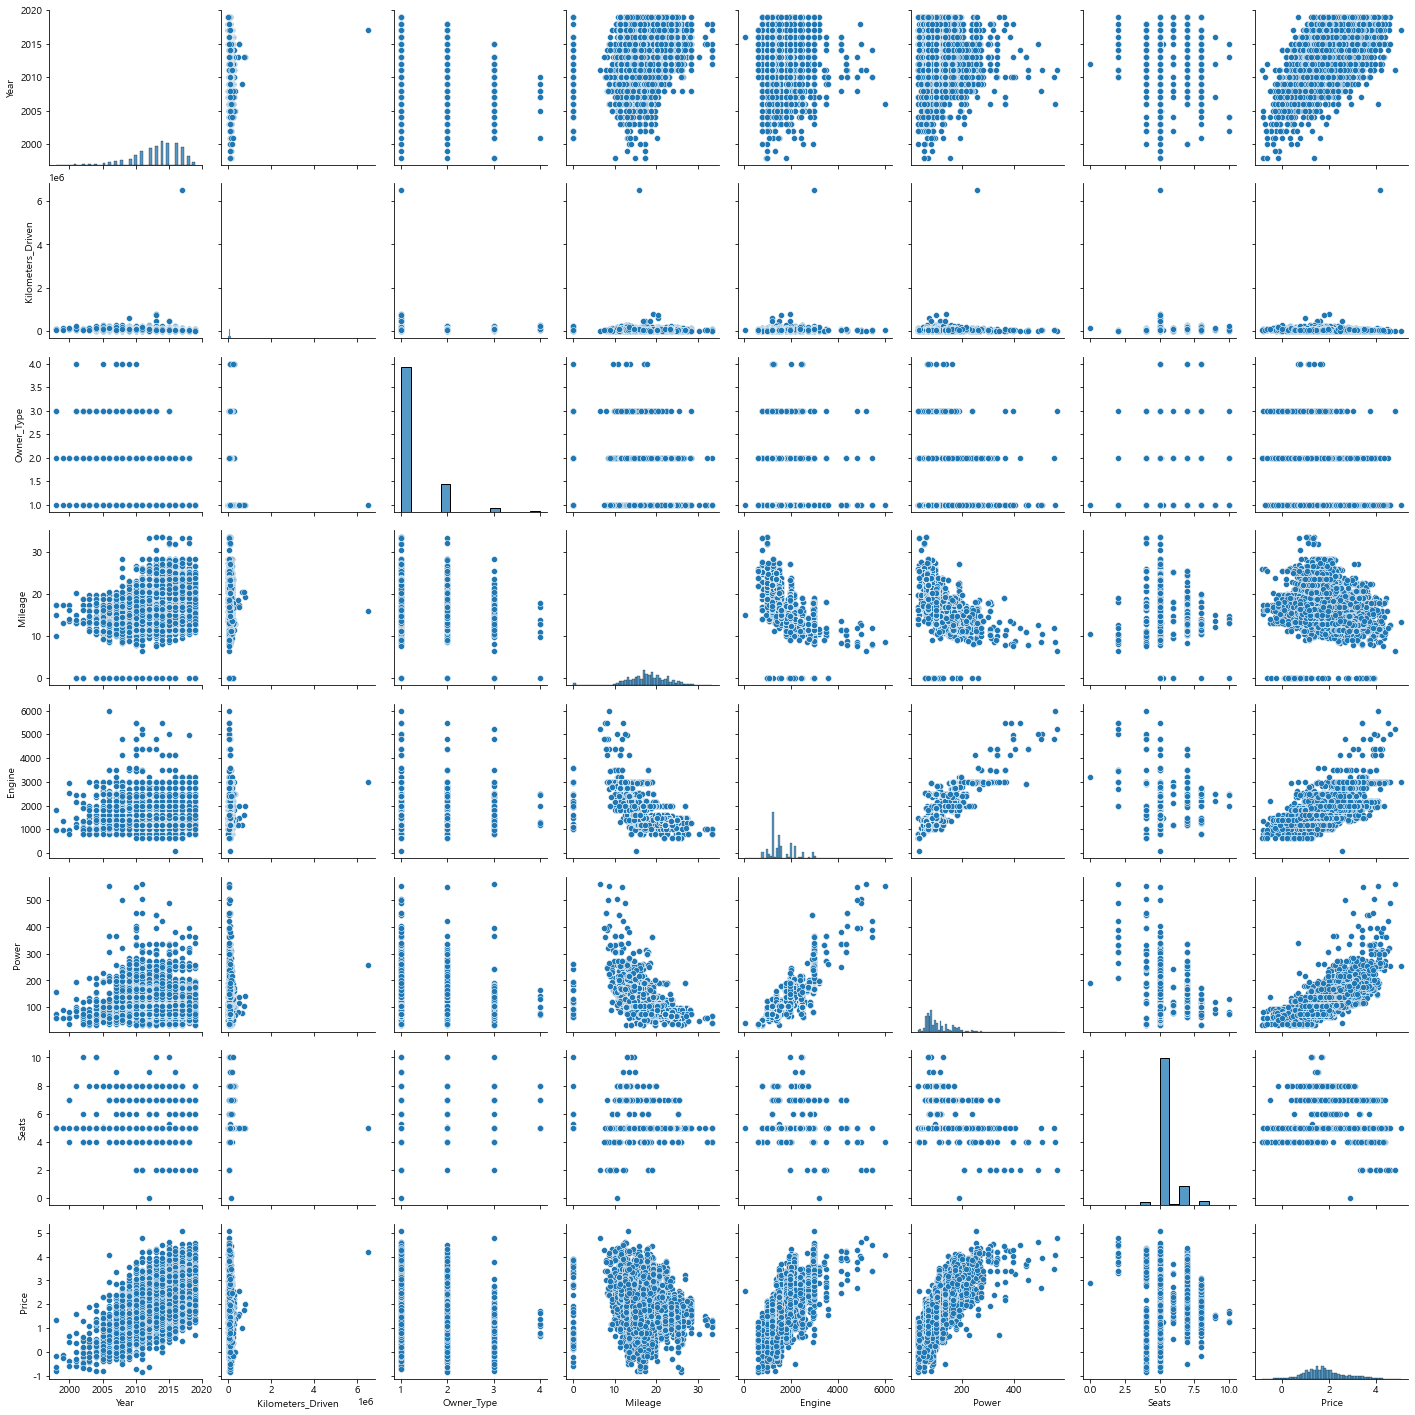

In [100]:
int_col = data.describe().columns
plt.figure(figsize=(10,10))
sns.pairplot(pd.concat([X,log_y],axis=1)[int_col])
plt.show()

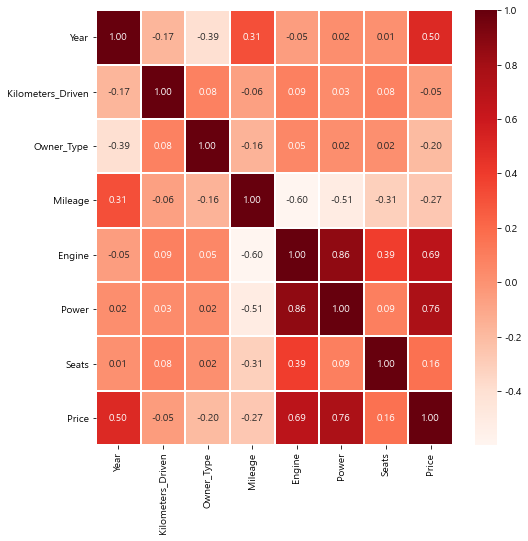

In [101]:
plt.rc('font', family='Malgun Gothic')
plt.rc("axes",unicode_minus=False)
plt.figure(figsize=(8,8))
sns.heatmap(pd.concat([X,log_y],axis=1)[int_col].corr(), cmap = 'Reds', annot=True, fmt = '.2f', linewidths=1)
plt.show()

 Power,Engine, Year 순으로 price 와 상관관계(선형관계)가 있음을 확인할 수 있습니다.
 
 다음으로 backward 를 통해 변수 선택을 진행하겠습니다.

In [109]:
select = []
model_reg = sm.OLS(log_y, X).fit()
column_list = X.columns.tolist()
step = 0
steps = []
sv_per_step = []
ad_r = []
while len(column_list) > 0 :
    b_X = sm.add_constant(X[column_list])
    p_values = sm.OLS(log_y,b_X).fit().pvalues[1:]
    max_pval = p_values.max()
    if max_pval >= 0.05 :
        remove_col = p_values.idxmax()
        print(remove_col)
        column_list.remove(remove_col)
        step += 1
        steps.append(step)
        adj_r = sm.OLS(log_y,sm.add_constant(X[column_list]))
        ad_r.append(adj_r)
        sv_per_step.append(column_list.copy())
    else :
        break

company_Skoda
company_Honda


company_Skoda, company_Honda 2개의 칼럼이 제거되었습니다.

### 1) Linear Regression

In [111]:
from sklearn.model_selection import train_test_split
X_reg = X[column_list]

X_train, X_test, y_train, y_test = train_test_split(X_reg, log_y, test_size=0.2, random_state=44)

In [112]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (4782, 47)
X_test (1196, 47)
y_train (4782,)
y_test (1196,)


In [121]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred_train = lr.predict(X_train)
lr_pred_test = lr.predict(X_test)

Text(0.5, 1.0, 'feature importace')

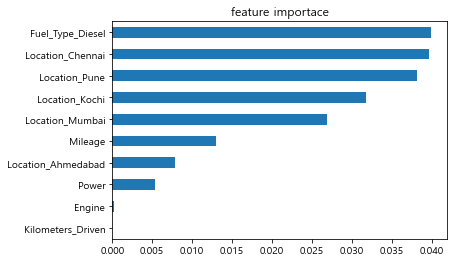

In [122]:
features = abs(pd.Series(index = X_train.columns, data = lr.coef_)).sort_values(ascending=True)
features[:10].plot.barh()
plt.title('feature importace')

피쳐임포턴스를 뽑아 봤을 때, Fuel_Type_Diesel, Location_Chennai, Location_Pune 순으로 중요도가 출력됩니다.

R-squared 도 0.9로 높습니다.

In [123]:
print('Linear regression train R-squared: ',lr.score(X_train, y_train))
print('Linear regression test R-squared : ',lr.score(X_test, y_test))

Linear regression train R-squared:  0.9254394129816437
Linear regression test R-squared :  0.9252937681861526


### 2) Ridge

In [127]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=44) 
ridge.fit(X_train, y_train)
ridge_pred_train = ridge.predict(X_train)
ridge_pred_test = ridge.predict(X_test)

Text(0.5, 1.0, 'feature importace')

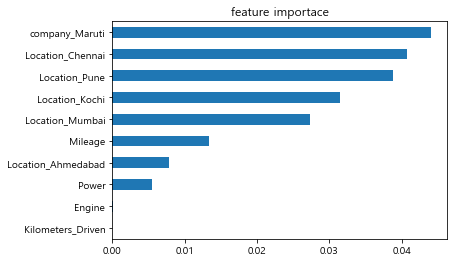

In [128]:
features = abs(pd.Series(index = X_train.columns, data = ridge.coef_)).sort_values(ascending=True)
features[:10].plot.barh()
plt.title('feature importace')

피쳐임포턴스를 뽑아 봤을 때, company_Maruti, Location_Chennai, Location_Pune 순으로 중요도가 출력됩니다. linear reg 와 피쳐 중요도가 비슷합니다.

R-squared 도 0.9로 높습니다.

In [129]:
print('Ridge train R-squared: ',ridge.score(X_train, y_train))
print('Ridge test R-squared : ',ridge.score(X_test, y_test))

Ridge train R-squared:  0.9253180032552956
Ridge test R-squared :  0.9249452851645178


### 3) Lasso

In [130]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=44)
lasso.fit(X_train, y_train)
lasso_pred_train = lasso.predict(X_train)
lasso_pred_test = lasso.predict(X_test)

Text(0.5, 1.0, 'feature importace')

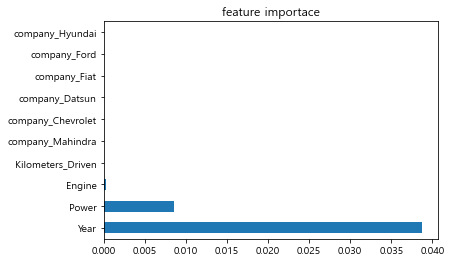

In [135]:
features = abs(pd.Series(index = X_train.columns, data = lasso.coef_)).sort_values(ascending=False)
features[:10].plot.barh()
plt.title('feature importace')

In [136]:
print('Lasso train R-squared: ',lasso.score(X_train, y_train))
print('Lasso test R-squared : ',lasso.score(X_test, y_test))

Lasso train R-squared:  0.7066698624835335
Lasso test R-squared :  0.712597925450033


랏소의 경우 피처임포턴스도 대부분 0 입니다. 일부 덜 중요한 피처들이 0으로 수렴되는 모델이기 때문이라 그런 것 같습니다.

In [144]:
#마지막으로 3개 모델의 평가지표를 RMSE로 두어 최적의 회귀 모델을 확인해 보겠습니다.
from sklearn.metrics import mean_squared_error

In [146]:
print('linear test MSE    : ',mean_squared_error(y_test, lr_pred_test)**0.5)
print('ridge test MSE     : ',mean_squared_error(y_test, ridge_pred_test)**0.5)
print('lasso test MSE     : ',mean_squared_error(y_test, lasso_pred_test)**0.5)

linear test MSE    :  0.2348603502612989
ridge test MSE     :  0.23540749083347776
lasso test MSE     :  0.4606554758327312


linear reg , ridge, lasso 순으로 평가지표가 우수합니다.